In [1]:
#second submission adding weekday
# Import pandas & numpy & regular expression
import pandas as pd
import numpy as np
import re
# Sklearn has a helper that makes it easy to do cross validation
from sklearn.cross_validation import cross_val_score
# Import the logistic regression class
from sklearn.linear_model import LogisticRegression
# Import the random forest model class
from sklearn.ensemble import RandomForestClassifier
# Import the gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train.csv', header=0)

In [3]:
train_df[0:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017


In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.5+ MB
None


In [5]:
def print_unique(df, list):
    for column in list:
        print("\n Totally there are " + str(len(df[column].unique())) + "  " +df[column].name)
        
#print_unique(train_df,["VisitNumber","TripType", "DepartmentDescription", "FinelineNumber",'Upc'])

In [6]:
#fillna
train_df.DepartmentDescription = train_df.DepartmentDescription.fillna('nan')
vistors = list(train_df.VisitNumber.unique())
depts = list(train_df.DepartmentDescription.unique())
types = list(train_df.TripType.unique())
## sort for future predict submission
types.sort()
weekdays = list(train_df.Weekday.unique())
print(types)
#print(np.min(vistors))

[3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 999]


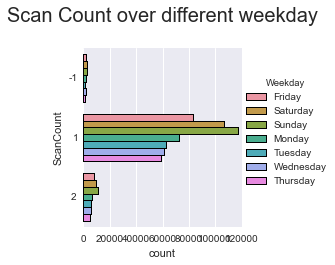

In [7]:
fig_scancount = sns.factorplot( y='ScanCount', data=train_df[  (train_df["ScanCount"] < 3 ) & (train_df["ScanCount"] >= -1 )], \
                     hue = 'Weekday' ,kind='count', size=3, linewidth=1)
sns.plt.title('Scan Count over different weekday \n' , size =20)

## Start training

In [8]:
dept_matrix_train = np.zeros((len(vistors),len(depts)))
print(dept_matrix_train.shape)
trip_type_train = np.zeros((len(vistors),len(types)))
print(trip_type_train.shape)
count_train = np.zeros((len(set(vistors)),1))
print(count_train.shape)
# new matrix
weekday_train = np.zeros((len(set(vistors)),7))
print(weekday_train.shape)

(95674, 69)
(95674, 38)
(95674, 1)
(95674, 7)


In [9]:
'''print(depts)
tmp = train_df.DepartmentDescription[64000]
print(tmp)
print(depts.index(tmp))
len(vistors)'''

'print(depts)\ntmp = train_df.DepartmentDescription[64000]\nprint(tmp)\nprint(depts.index(tmp))\nlen(vistors)'

In [10]:
i=0
j=0
dept_matrix_train[j,depts.index(train_df.DepartmentDescription[i])] = train_df.ScanCount[i]
trip_type_train[j,types.index(train_df.TripType[i])] = 1
count_train[j] = 1
weekday_train[j, weekdays.index(train_df.Weekday[i])] = 1

## generate matrix for random forrest

In [11]:
for i in range(1,len(train_df)):
    if (train_df.VisitNumber[i] != train_df.VisitNumber[i-1]):
        j = j + 1
        trip_type_train[j,types.index(train_df.TripType[i])] = 1
        count_train[j] = 1
    elif (train_df.TripType[i] != train_df.TripType[i-1]):
        print("ERROR! Different trip type assigned for same visit!")
        count_train[j] += 1
    else:
        count_train[j] += 1
    dept_matrix_train[j,depts.index(train_df.DepartmentDescription[i])] += train_df.ScanCount[i]
    weekday_train[j,weekdays.index(train_df.Weekday[i])] = 1

In [15]:
print('Total transaction count: ' + str(sum(count_train)))

Total transaction count: [ 647054.]


In [16]:
#merge together
dept_weekday_matrix_train = np.hstack((weekday_train, dept_matrix_train))
print(dept_weekday_matrix_train.shape)
dept_weekday_matrix_train[0:3]

(95674, 76)


array([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,  -1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,

In [17]:
alg = RandomForestClassifier(n_estimators=150, min_samples_split=8, min_samples_leaf=4, n_jobs=-1)
# 150 error larger than 100

In [18]:
alg.fit(dept_weekday_matrix_train, trip_type_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## test date read in and transform

In [19]:
test_df = pd.read_csv('data/test.csv', header=0)

In [20]:
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653646 entries, 0 to 653645
Data columns (total 6 columns):
VisitNumber              653646 non-null int64
Weekday                  653646 non-null object
Upc                      649660 non-null float64
ScanCount                653646 non-null int64
DepartmentDescription    652318 non-null object
FinelineNumber           649660 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 34.9+ MB
None


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002
1,1,Friday,1707710732,1,DAIRY,1526
2,1,Friday,89470001026,1,DAIRY,1431
3,1,Friday,88491211470,1,GROCERY DRY GOODS,3555
4,2,Friday,2840015224,1,DSD GROCERY,4408


In [21]:
test_df.DepartmentDescription = test_df.DepartmentDescription.fillna('nan')

In [22]:
def print_unique(df, list):
    for column in list:
        print("\n Totally there are " + str(len(df[column].unique())) + "  " +df[column].name)
        
#print_unique(test_df,["VisitNumber","Upc", "DepartmentDescription", "FinelineNumber" ])

In [23]:
dept_matrix_test = np.zeros((len(set(test_df.VisitNumber)),len(depts)))
count_test = np.zeros((len(set(test_df.VisitNumber)),1))
# new matrix
weekday_test = np.zeros((len(set(test_df.VisitNumber)),7))
i=0
j=0
dept_matrix_test[j,depts.index(test_df.DepartmentDescription[i])] = test_df.ScanCount[i]
count_test[j] = 1
weekday_test[j, weekdays.index(test_df.Weekday[i])] = 1

In [24]:
for i in range(1,len(test_df)):
    if (test_df.VisitNumber[i] != test_df.VisitNumber[i-1]):
        j = j + 1
        count_test[j] = 1
    else:
        count_test[j] += 1
    dept_matrix_test[j,depts.index(test_df.DepartmentDescription[i])] += test_df.ScanCount[i]    
    weekday_test[j,weekdays.index(test_df.Weekday[i])] = 1

In [26]:
print('Total transaction count: ' + str(sum(count_test)))

Total transaction count: [ 653646.]


In [27]:
#print(test_df[0:30])
#dept_matrix_test[0:10]
print(dept_matrix_test.shape)
#merge together
dept_weekday_matrix_test = np.hstack((weekday_test, dept_matrix_test))
print(dept_weekday_matrix_test.shape)
#dept_weekday_matrix_test[8860:8865]

(95674, 69)
(95674, 76)


In [28]:
prediction_20000 = alg.predict(dept_weekday_matrix_test[0:20000])

In [29]:
prediction_40000 = alg.predict(dept_weekday_matrix_test[20000:40000])

In [30]:
prediction_60000 = alg.predict(dept_weekday_matrix_test[40000:60000])

In [31]:
prediction_80000 = alg.predict(dept_weekday_matrix_test[60000:80000])

In [32]:
prediction_90000 = alg.predict(dept_weekday_matrix_test[80000:])

In [33]:
prediction = np.concatenate((prediction_20000, prediction_40000, prediction_60000, prediction_80000, prediction_90000))

In [34]:
prediction.shape

(95674, 38)

In [35]:
prediction_list = prediction.tolist()

## submission format

In [36]:
sample_sub_df = pd.read_csv('data/sample_submission.csv', header=0)

In [37]:
sample_sub_df.columns

Index(['VisitNumber', 'TripType_3', 'TripType_4', 'TripType_5', 'TripType_6',
       'TripType_7', 'TripType_8', 'TripType_9', 'TripType_12', 'TripType_14',
       'TripType_15', 'TripType_18', 'TripType_19', 'TripType_20',
       'TripType_21', 'TripType_22', 'TripType_23', 'TripType_24',
       'TripType_25', 'TripType_26', 'TripType_27', 'TripType_28',
       'TripType_29', 'TripType_30', 'TripType_31', 'TripType_32',
       'TripType_33', 'TripType_34', 'TripType_35', 'TripType_36',
       'TripType_37', 'TripType_38', 'TripType_39', 'TripType_40',
       'TripType_41', 'TripType_42', 'TripType_43', 'TripType_44',
       'TripType_999'],
      dtype='object')

In [38]:
#types.sort()
print(types)
types_str = []
for type in types:
    types_str.append("TripType_" + str(type))
print(types_str)
print(test_df["VisitNumber"].unique()[0:10])

[3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 999]
['TripType_3', 'TripType_4', 'TripType_5', 'TripType_6', 'TripType_7', 'TripType_8', 'TripType_9', 'TripType_12', 'TripType_14', 'TripType_15', 'TripType_18', 'TripType_19', 'TripType_20', 'TripType_21', 'TripType_22', 'TripType_23', 'TripType_24', 'TripType_25', 'TripType_26', 'TripType_27', 'TripType_28', 'TripType_29', 'TripType_30', 'TripType_31', 'TripType_32', 'TripType_33', 'TripType_34', 'TripType_35', 'TripType_36', 'TripType_37', 'TripType_38', 'TripType_39', 'TripType_40', 'TripType_41', 'TripType_42', 'TripType_43', 'TripType_44', 'TripType_999']
[ 1  2  3  4  6 13 14 16 18 21]


In [39]:
output_df = pd.DataFrame(prediction_list, columns = types)
output_df_2 = output_df.reindex_axis(sorted(output_df.columns), axis=1)
output_df_2.columns = types_str
output_df_2.insert(0, "VisitNumber", test_df["VisitNumber"].unique())
output_df_2["VisitNumber"] = test_df["VisitNumber"].unique()
output_df_2[0:5]

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
output_df_2.to_csv("submission_3.csv", index=False)